# Image Captioning Neural Model (SC4001)

In [ ]:
!pip install pillow opencv-python nltk

In [17]:
import os
from PIL import Image
import cv2
import random
from textwrap import wrap

import math

import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201, InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

### 1.1 Retrieving the datasets

In [32]:
captions = pd.read_csv('./flickr30k_images/captions.csv', delimiter='|')
image_path = './flickr30k_images/flickr30k_images'
images = os.listdir(image_path)

valid_imgExt = [".jpg", ".jpeg", ".png"]

image_size = [(64, 64), (128, 128), (224, 224), (256, 256)]

# We will first use (224, 244) image size

def show_images(num, images):
    plt.figure(figsize=(25, 25))

    # Randomly select images
    r = random.randint(0, len(images)-num-1)

    for i, filename in enumerate(images[r:r+num]):
        if os.path.splitext(filename)[1].lower() not in valid_imgExt:
            continue
        with open(os.path.join(image_path, filename), 'rb') as img:
            img = Image.open(img).resize(image_size[2])
            plt.subplot(5, 5, i+1)
            plt.imshow(img)
            plt.title("\n".join(wrap(get_caption(filename, captions), 20)))
            plt.subplots_adjust(hspace=0.8)
            img.close()

    plt.show()

def get_caption(filename, captions):
    cap = captions[captions['image_name'] == filename][' comment'].values
    return cap[random.randint(0, len(cap)-1)]

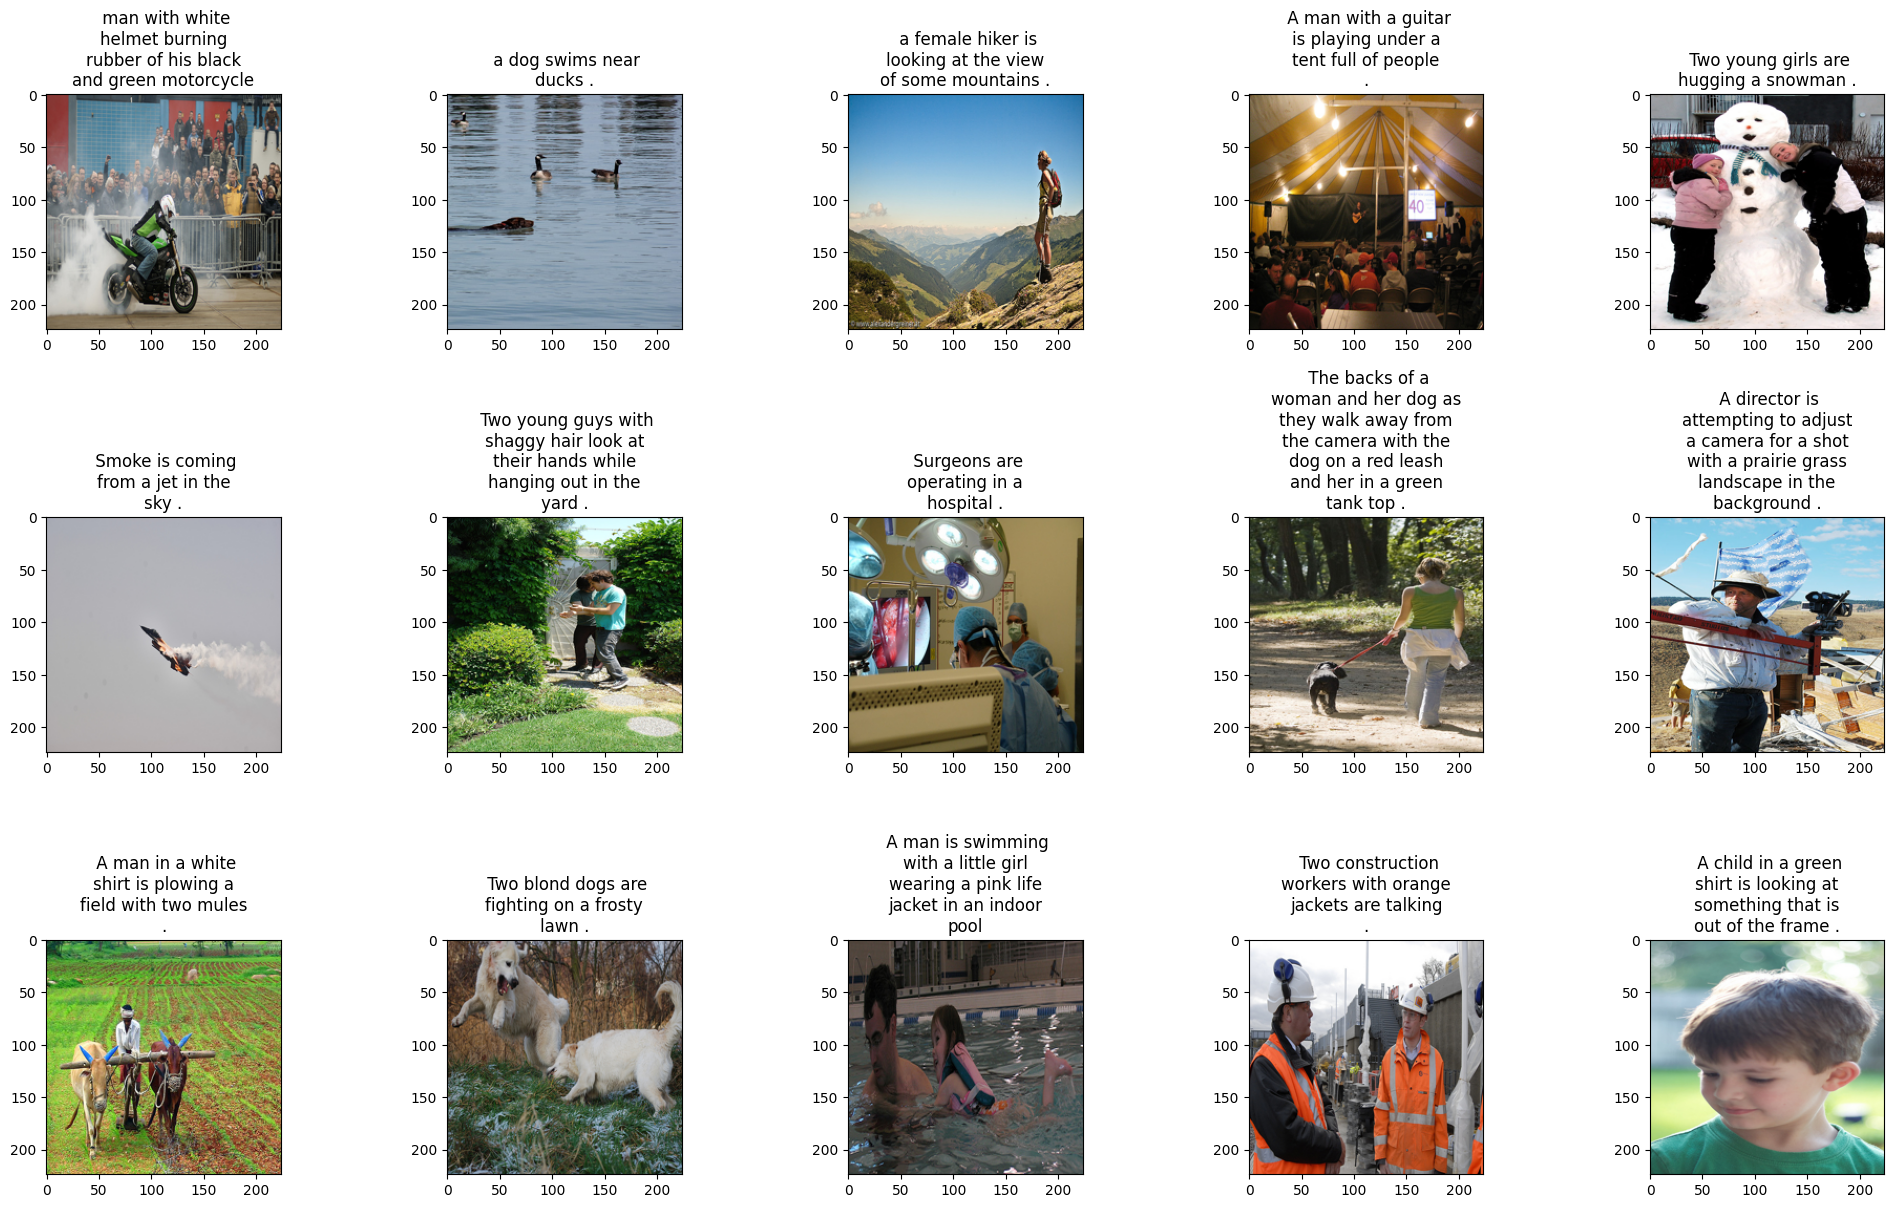

In [33]:
show_images(15, images)

### 1.2 Analysing datasets
- Images
- Captions

In [7]:
# images dataset
total_width = total_height = 0

for filename in images:
    try:
        if os.path.splitext(filename)[1].lower() not in valid_imgExt:
            continue
        with open(os.path.join(image_path, filename), 'rb') as file:
            img = Image.open(file)
            width, height = img.size

            total_width += width
            total_height += height
            img.close()
    except Exception as e:
        print(f"Skipping {filename} due to error: {e}")

average_width = total_width / len(images)
average_height = total_height / len(images)

print(f"Average Width: {average_width:.4f}")
print(f"Average Height: {average_height:.4f}")

Average Width: 459.5782
Average Height: 395.1066


In [22]:
# captions dataset
display(captions.head(10))
print("We can observe that there are multiple captions for each image, denoted by \'comment_number\'.")

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .
5,10002456.jpg,0,Several men in hard hats are operating a gian...
6,10002456.jpg,1,Workers look down from up above on a piece of...
7,10002456.jpg,2,Two men working on a machine wearing hard hats .
8,10002456.jpg,3,Four men on top of a tall structure .
9,10002456.jpg,4,Three men on a large rig .


We can observe that there are multiple captions for each image, denoted by 'comment_number'.


### 2.1 Clean captions dataset

- Convert all char to lowercase
- Remove unncecessary white spaces
- Only allow valid char in the English language
- Remove special char eg. '&', '*', '(', ')', etc

In [92]:
def text_preprocessing(df):
    df[' comment'] = df[' comment'].str.lower()
    df[' comment'] = df[' comment'].str.replace("[^A-Za-z]", " ", regex=True)
    df[' comment'] = df[' comment'].str.replace("\s+", " ", regex=True)
    df[' comment'] = df[' comment'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))
    df[' comment'] = "Sseq " + df[' comment'] + " Eseq"
    return df

captions_clean = captions.copy()
captions_clean = text_preprocessing(captions_clean)
captions_list = captions_clean[' comment'].tolist()
captions_list[:10]

['Sseq two young guys with shaggy hair look at their hands while hanging out in the yard Eseq',
 'Sseq two young white males are outside near many bushes Eseq',
 'Sseq two men in green shirts are standing in yard Eseq',
 'Sseq man in blue shirt standing in garden Eseq',
 'Sseq two friends enjoy time spent together Eseq',
 'Sseq several men in hard hats are operating giant pulley system Eseq',
 'Sseq workers look down from up above on piece of equipment Eseq',
 'Sseq two men working on machine wearing hard hats Eseq',
 'Sseq four men on top of tall structure Eseq',
 'Sseq three men on large rig Eseq']

### 2.2 Tokenise captions dataset

In [94]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions_list)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions_clean)

images = captions_clean['image_name'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = captions_clean[captions_clean['image_name'].isin(train_images)]
test = captions_clean[captions_clean['image_name'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions_list[1]])[0]

[1, 12, 21, 20, 706, 13, 54, 79, 192, 1419, 2]

### 2.3 Data Generator

In [ ]:
def dataGenerator(df, batch_size, directory, tokenizer, vocab_size, max_length, features):

    batch = df.iloc[index * batch_size:(index + 1) * batch_size,:]
    X1, X2, y = list(), list(), list()
        
    images = batch["image_name"].tolist()
        
    for image in images:
        feature = features[image][0]
        
        captions = batch.loc[batch["image_name"]==image, "comment"].tolist()
        for caption in captions:
            seq = tokenizer.texts_to_sequences([caption])[0]

            for i in range(1,len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                X1.append(feature)
                X2.append(in_seq)
                y.append(out_seq)
        
    X1, X2, y = np.array(X1), np.array(X2), np.array(y)

    return (X1, X2), y

In [ ]:
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for filename, description_list in descriptions.items():
            #retrieve photo features
            feature = features[filename][0]
            inp_image, inp_seq, op_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[inp_image, inp_seq], op_word]

def create_sequences(tokenizer, max_length, desc_list, feature):
    x_1, x_2, y = list(), list(), list()
    # move through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # divide one sequence into various X,y pairs
        for i in range(1, len(seq)):
            # divide into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            x_1.append(feature)
            x_2.append(in_seq)
            y.append(out_seq)

    return np.array(x_1), np.array(x_2), np.array(y)

### 3.1 Define pretrained CNN models for image feature extraction

In [18]:
model1, model2, model3, model4 = VGG16(), DenseNet201(), InceptionV3(), ResNet50()

102967424/102967424 [==============================] - 9s 0us/step


### 3.1.1 Feature extraction

In [67]:
features1 = features2 = features3 = features4 = {}

feature_ex1 = Model(inputs=model1.input, outputs=model1.layers[-2].output)
feature_ex2 = Model(inputs=model2.input, outputs=model2.layers[-2].output)
feature_ex3 = Model(inputs=model3.input, outputs=model3.layers[-2].output)
feature_ex4 = Model(inputs=model4.input, outputs=model4.layers[-2].output)

def feature_extraction(feature_ex, images, features):
    for filename in tqdm(images):
        try:
            if os.path.splitext(filename)[1].lower() not in valid_imgExt:
                continue
            with open(os.path.join(image_path, filename), 'rb') as img:
                img = Image.open(img).resize(image_size[2])
                img = img_to_array(img)
                # Normalise image pixel values [0,255] -> [0,1]
                img = img/255
                img = np.expand_dims(img, axis=0)
                feature = feature_ex(img)
                features[filename] = feature
        except Exception as e:
            print(f"Skipping {filename} due to error: {e}")

In [ ]:
# model1 VGG16
feature_extraction(feature_ex1, images, features1)

# model2 DenseNet201
feature_extraction(feature_ex2, images, features2)

# model3 InceptionV3
feature_extraction(feature_ex3, images, features3)

# model4 ResNet50
feature_extraction(feature_ex4, images, features4)

### 3.2 Define the network (CNN + LSTM)

### 3.3 Train the model using different CNN models

### 3.3.1 VGG16

### 3.3.2 DenseNet201

### 3.3.3 InceptionV3

### 3.3.4 ResNet50

### 3.4 Evaluate CNN models

### 4.1